# implement line sweeps of params
- all params fixed expcet one, which is swept over range
- specifically looking at test accuracy as a function of one param


In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## timestamp and dir for saving
tstamp = time.perf_counter_ns()
import os
os.mkdir('figures/scratch_folders/%i'%tstamp)

testacc-param_sweep-lrate-default_concentration_1.400-stickiness_wi_5000.000-stickiness_bt_4.000-sparsity_0.080-pvar_0.000-lrate_1.000-t1556963830.png

In [3]:
## default params
expargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
schargs = {
   'concentration':3,
   'stickiness_wi':10,
   'stickiness_bt':10,
   'sparsity':1,
   'pvar': 0,
   'lrate':1,
   'lratep':.3,
   'decay_rate':1,
}
semargs = {
  'beta2':False,
  'skipt1':True,
  'ppd_allsch':False
}
args = {
    'sem':semargs,
    'sch':schargs,
    'exp':expargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str += "-"+"-".join(["%s_%.3f"%(i,j) for i,j in semargs.items()])
param_str

'concentration_3.000-stickiness_wi_10.000-stickiness_bt_10.000-sparsity_1.000-pvar_0.000-lrate_1.000-lratep_0.300-decay_rate_1.000-beta2_0.000-skipt1_1.000-ppd_allsch_0.000'

In [4]:
p_name = 'concentration' # 
p_vals = np.arange(1,5,.25)

p_name = 'stickiness_wi' # 5000
p_vals = np.arange(5,15,1)

# p_name = 'stickiness_bt' # 100
# p_vals = np.arange(0.01,5,.5)

# p_name = 'sparsity' # 0.08
# p_vals = np.arange(0.01,1,0.1)

# p_name = 'pvar' # 0
# p_vals = np.arange(0,2,0.2)

# p_name = 'lrate' # 1
# p_vals = np.arange(0.8,1.01,0.05)

# p_name = 'lratep' # 1
# p_vals = np.arange(.01,.5,.05)

# p_name = 'decay_rate' # 1
# p_vals = np.arange(0.98,1.000001,0.001)

p_name,p_vals

('stickiness_wi', array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))

### main

In [5]:
def pltsave_macc(macc,schargs=None,labL=['B','I','E','M','L'],close=True):
  """ 
  save accuracy of individual parameter setting 
  used in paramsearch loops
  """
  plt.figure(figsize=(10,4))
  ax=plt.gca()
  for idx in range(len(macc)):
    ax.plot(macc[idx],label=labL[idx])
  ax.axhline(0.5,c='k')
  plt.legend()
  param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
  plt.savefig('figures/scratch_folders/%i/acc-%s.jpg'%(tstamp,param_str))
  if close:
    plt.close('all')
  return None


In [6]:
ns = 20
dfL = []
condL = ['blocked','interleaved','early','middle','late']
for idx,p_val in enumerate(p_vals):
  print(idx/len(p_vals))
  
  args['sch'][p_name] = p_val  
  exp_batch_data = run_batch_exp_curr(ns,args,condL)
  ## acc
  batch_acc = unpack_acc(exp_batch_data) # curr,seeds,trials
  mean_acc = batch_acc.mean(1)
  test_acc = mean_acc[:,-40:].mean(1) # curr  
  
  ## save traces of EML for each param setting
  pltsave_macc(mean_acc[2:],args['sch'],labL=['E','M','L'])
  
  ## record
  gsD = {
    **schargs,
    **dict(zip(condL,test_acc))
  }
  dfL.append(gsD)
  
gsdf = pd.DataFrame(dfL)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [7]:
gsdf ## test acc dataframe

,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late
0,3,5,10,1,0,1,0.3,1,0.722437,0.499847,0.722449,0.499198,0.500344
1,3,6,10,1,0,1,0.3,1,0.722466,0.500529,0.722431,0.499661,0.499992
2,3,7,10,1,0,1,0.3,1,0.722497,0.499514,0.722427,0.500597,0.499875
3,3,8,10,1,0,1,0.3,1,0.722445,0.499458,0.722463,0.499603,0.500299
4,3,9,10,1,0,1,0.3,1,0.722499,0.500019,0.722436,0.500815,0.500594
5,3,10,10,1,0,1,0.3,1,0.722465,0.499416,0.722488,0.499504,0.500023
6,3,11,10,1,0,1,0.3,1,0.722478,0.501419,0.722501,0.499779,0.499490
7,3,12,10,1,0,1,0.3,1,0.722414,0.499387,0.722448,0.500127,0.500145
8,3,13,10,1,0,1,0.3,1,0.722466,0.499774,0.722514,0.500021,0.499122
9,3,14,10,1,0,1,0.3,1,0.722426,0.499192,0.722472,0.499485,0.500071


### plt 

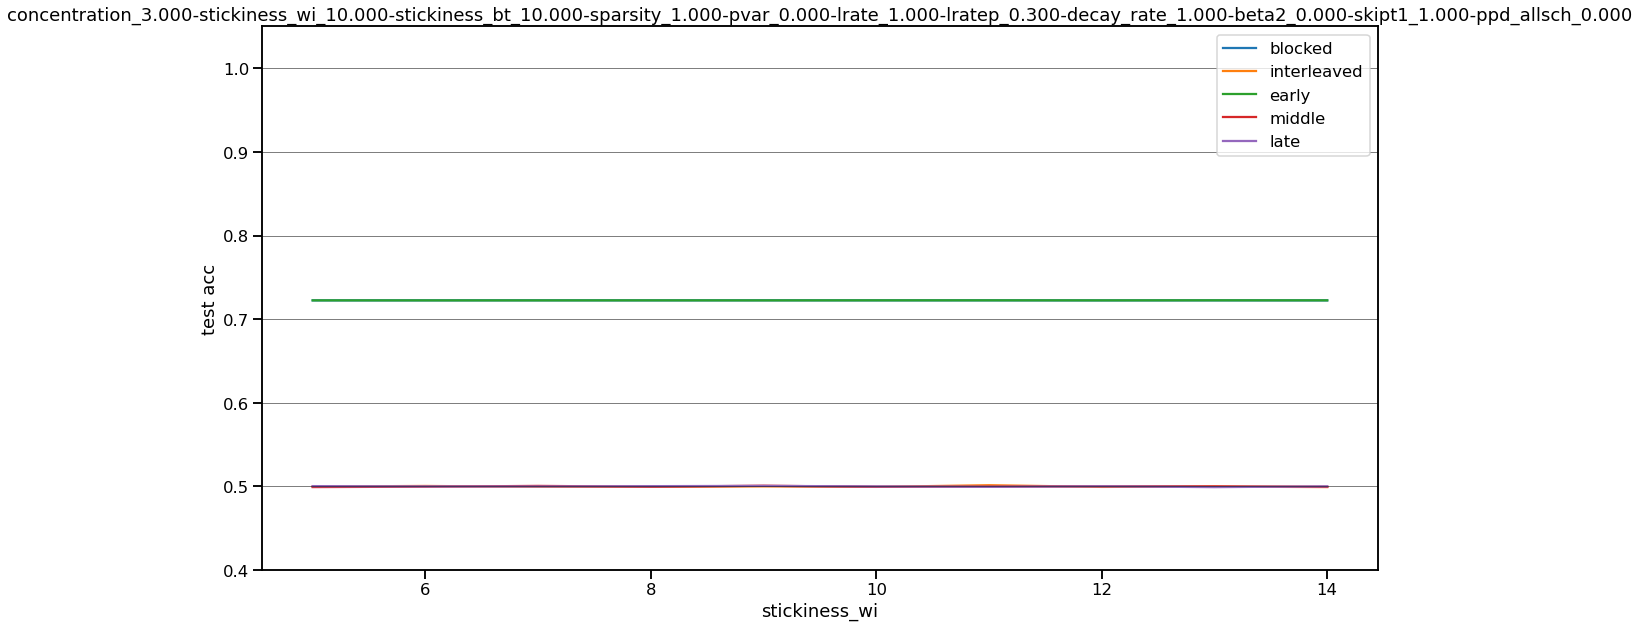

In [8]:
plt.figure(figsize=(20,10))
ax = plt.gca()
gsdf.plot(p_name,condL,ax=ax)
ax.set_ylim(0.4,1.05)
ax.set_ylabel('test acc')
for i in np.arange(0.5,1.01,0.1):
  ax.axhline(i,c='k',lw=0.5)
plt.title(param_str)
plt.savefig('figures/scratch/testacc-sweep_%s-default_%s-t%s.png'%(
  p_name,param_str,tstamp))